In [277]:
import numpy as np
import igraph as ig
import geopandas as gpd
import pandas as pd
import math
from typing import Tuple, List
from sklearn.neighbors import KernelDensity
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None

In [278]:
g = ig.load('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset/graph.gml')
census = gpd.read_file('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset/census_data.geojson')

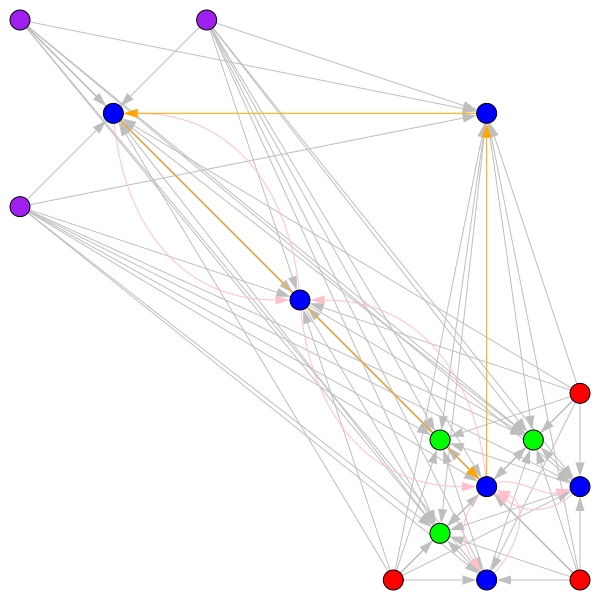

In [279]:
ig.plot(g)

In [280]:
census

,neighborhood,n_inh,n_purple,n_red,geometry
0,RC1,1000,100,900,POINT (3.50000 3.50000)
1,RC2,1000,200,800,POINT (2.50000 3.50000)
2,RC3,1000,200,800,POINT (3.50000 2.50000)
3,RC4,1200,1000,200,POINT (0.50000 1.50000)
4,RC5,800,600,200,POINT (0.50000 0.50000)
5,RC6,1000,1000,0,POINT (1.50000 0.50000)


# Helper Functions

In [281]:
g.vs.select(type_eq='res_node')['name']

['RC1', 'RC2', 'RC3', 'RC4', 'RC5', 'RC6']

In [282]:
def evaluate_graph(g: ig.Graph) -> pd.DataFrame:
    nb_nodes = g.vs.select(type_eq='res_node')
    poi_nodes = g.vs.select(type_eq='poi_node')

    tt_mx = np.zeros((len(nb_nodes), len(poi_nodes)))
    hops_mx = np.zeros((len(nb_nodes), len(poi_nodes)))

    failed = {}

    for i, o in enumerate(nb_nodes):
        for j, d in enumerate(poi_nodes):
            # Travel Time
            tt = g.shortest_paths(o, d, weights='tt')[0][0]
            if tt == math.inf:
                if not failed.get(f"{o['node_id']}_tt", None) == d['node_id']:
                    failed[f"{o['node_id']}_tt"] = d["node_id"]
            else:
                tt_mx[i, j] = tt
            # Number of hops
            edges = g.get_shortest_paths(o, d, weights='tt', output='epath')[0]
            if edges == math.inf or not edges:
                if not failed.get(f"{o['node_id']}_edges", None) == d["node_id"]:
                    failed[f"{o['node_id']}_edges"] = d["node_id"]
            else:
                hops_mx[i, j] = len(edges)

    df_tt = pd.DataFrame(tt_mx, columns=poi_nodes['name'])
    df_tt['metric'] = 'travel_time'
    df_tt['rc'] = nb_nodes['name']

    df_hops = pd.DataFrame(hops_mx, columns=poi_nodes['name'])
    df_hops['metric'] = 'hops'
    df_hops['rc'] = nb_nodes['name']

    return pd.concat([df_tt,df_hops], axis=0)

In [283]:
df = evaluate_graph(g)
df

,POI1,POI2,POI3,metric,rc
0,10.542641,9.486833,9.486833,travel_time,RC1
1,9.486833,4.242641,11.191324,travel_time,RC2
2,9.486833,10.542641,4.242641,travel_time,RC3
3,12.940054,12.940054,12.940054,travel_time,RC4
4,12.940054,12.940054,12.940054,travel_time,RC5
5,12.940054,12.940054,12.940054,travel_time,RC6
0,3.000000,1.000000,1.000000,hops,RC1
1,1.000000,1.000000,3.000000,hops,RC2
2,1.000000,3.000000,1.000000,hops,RC3
3,3.000000,3.000000,3.000000,hops,RC4


In [284]:
def generate_samples(metric_df: pd.DataFrame, inh_per_group: pd.DataFrame):
    merged_df = pd.merge(metric_df, inh_per_group, how='left', left_on='rc', right_on='neighborhood')

    city = pd.DataFrame(columns=['metric_value', 'group'])

    for group in merged_df.loc[:,merged_df.columns.str.contains('n_')].columns:
        samples_group = np.repeat(merged_df['average'].values, merged_df[group])
        samples_group = samples_group.reshape((-1,1))
        labels = np.repeat(group.replace('n_',''),samples_group.shape[0]).reshape((-1,1))
        group_individuals = np.hstack([samples_group, labels])
        df = pd.DataFrame(group_individuals, columns=['metric_value', 'group'])
        city = pd.concat([city, df], axis=0)

    return city

# Reward Functions

In [285]:
def egalitarian(g: ig.Graph, census_data: gpd.GeoDataFrame) -> float:
    # fit KDE (sklearn) on each component
    metric_df = evaluate_graph(g)
    groups_census = census.drop(columns=['n_inh','geometry'])

    metric_df['average'] = metric_df.loc[:,metric_df.columns.str.contains('POI')].mean(axis=1)
    tt_samples = generate_samples(metric_df[metric_df['metric']=='travel_time'], groups_census)
    hops_samples = generate_samples(metric_df[metric_df['metric']=='hops'], groups_census)

    value_cols = metric_df.loc[:,metric_df.columns.str.contains('POI')]
    metric_df['average'] = value_cols[value_cols>13].sum(axis=1)
    com_samples = generate_samples(metric_df[metric_df['metric']=='travel_time'], groups_census)

    kdes = {group: {metric: None for metric in ['tt','hops','com']} for group in tt_samples.group.unique()}

    for group in tt_samples.group.unique():
        for metric, metric_df in zip(['tt','hops','com'], [tt_samples, hops_samples, com_samples]):
            X = metric_df[metric_df.group==group].drop(columns='group').astype(float).to_numpy()
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
            kdes[group][metric] = kde
            # # score_samples returns the log of the probability density
            # x_d = np.linspace(0,X.max()+5, 100).reshape((-1,1))
            # logprob = kde.score_samples(x_d)
            # x_d = np.linspace(0,X.max()+5, 100)
            # plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
            # plt.plot(X, np.full_like(X, -0.01), '|k', markeredgewidth=1)

    # fit KDE on all aggregated data (mixture)

    # kde_mixture.entropy - 1/n_components * sum([kde_component.entropy  for  kde_component in components] )


In [286]:
egalitarian(g, census)

In [287]:
def utilitarian() -> float:
    pass

In [288]:
def elitarian() -> float:
    pass

# Random Baseline

# Fully Informed Greedy Baseline

# Genetic Algorithm Baseline

# Q-Learning